In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Due to the large amount of dataset, the Jupyter notebook was crashing multiple times ,I solved this by making checkpoitns on large training and storing theresults in .pkl files.
# The files are present in my github repo https://github.com/SumitKumar-17/Assignment-3-Checkpoints.


**Name:** Sumit Kumar
**Roll No:** 22CS30056

# Clustering Assignment: Unsupervised Image Clustering

**Course Name:** Machine Learning  
**Assignment Title:** Image Clustering with Textual Constraints  
**Submission Deadline:** 22/3/2025  



## 1. Dataset Description

This assignment uses the CIFAR-10 dataset, which contains 60,000 32x32 color images across 10 classes, with 6,000 images per class. The dataset is publicly available through TensorFlow/Keras or PyTorch libraries.

The 10 classes in CIFAR-10 are:
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck


In [ ]:
# Install required packages
!pip install torch torchvision torchaudio
!pip install sentence-transformers
# !pip install git+https://github.com/openai/CLIP.git
# !pip install openai-clip
!pip install seaborn scikit-learn matplotlib pandas
!pip install tqdm

^C
ERROR: Operation cancelled by user


In [ ]:

## 2. Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from sentence_transformers import SentenceTransformer

from PIL import Image
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [ ]:
device

device(type='cuda')

## 3. Pre-processing


### 3.1 Loading and Normalizing the CIFAR-10 Dataset


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)

# Combine train and test sets for clustering
fullset = torch.utils.data.ConcatDataset([trainset, testset])

# For demonstration, we'll use a subset of the data to make computation faster
# You can increase this number for better results
subset_size = 59000  # Using 5000 samples for demonstration
indices = list(range(len(fullset)))
random.shuffle(indices)
indices = indices[:subset_size]
dataset = Subset(fullset, indices)

# Create a data loader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Get class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Store original labels for evaluation
original_labels = []
for idx in indices:
    if idx < len(trainset):
        original_labels.append(trainset.targets[idx])
    else:
        original_labels.append(testset.targets[idx - len(trainset)])
original_labels = np.array(original_labels)



100%|██████████| 170M/170M [00:09<00:00, 17.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 3.2 Visualizing Sample Images


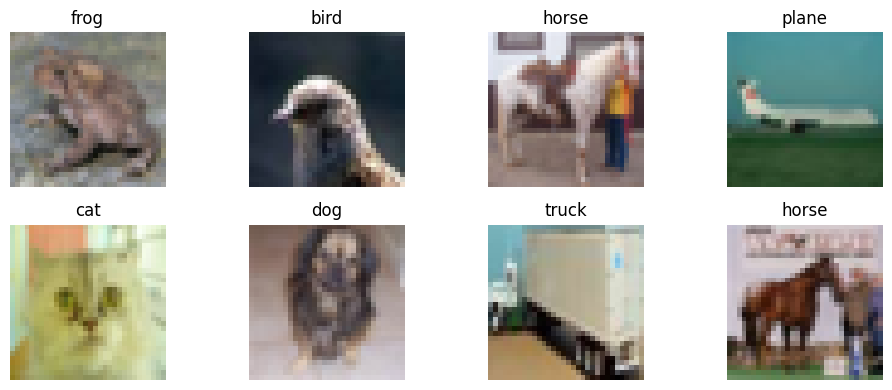

In [ ]:


# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()



## 4. Feature Extraction


### 4.1 Visual Feature Extraction using Pre-trained CNN


In [ ]:

# Load a pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

# Extract visual features
visual_features = []
batch_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        features = model(images)
        features = features.squeeze().cpu().numpy()
        visual_features.append(features)
        batch_labels.extend(labels.numpy())

visual_features = np.vstack(visual_features)
print(f"Visual features shape: {visual_features.shape}")



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


Visual features shape: (59000, 512)


### 4.2 Generating Image Captions using CLIP for Textual Features


In [ ]:
# Create the destination directory with parent directories if needed
!mkdir -p /kaggle/working/caption_checkpoints

# Copy all contents from inputr to the destination
!cp -r /kaggle/input/inputr/* /kaggle/working/caption_checkpoints/

# Verify the copy operation
!echo "Files copied from inputr to kaggle/working/caption_checkpoints"
!ls -la /kaggle/working/caption_checkpoints/  

Files copied from inputr to kaggle/working/caption_checkpoints
caption_checkpoints:
total 30172
drwxr-xr-x 2 root root    4096 Mar 21 13:24 .
drwxr-xr-x 5 root root    4096 Mar 21 13:21 ..
-rw-r--r-- 1 root root    1076 Mar 21 13:24 advanced_captions_checkpoint_0.pkl
-rw-r--r-- 1 root root    1790 Mar 21 13:24 advanced_captions_checkpoint_1.pkl
-rw-r--r-- 1 root root    2451 Mar 21 13:24 advanced_captions_checkpoint_2.pkl
-rw-r--r-- 1 root root    3101 Mar 21 13:24 advanced_captions_checkpoint_3.pkl
-rw-r--r-- 1 root root    3770 Mar 21 13:24 advanced_captions_checkpoint_4.pkl
-rw-r--r-- 1 root root    4482 Mar 21 13:24 advanced_captions_checkpoint_5.pkl
-rw-r--r-- 1 root root    5164 Mar 21 13:24 advanced_captions_checkpoint_6.pkl
-rw-r--r-- 1 root root    5860 Mar 21 13:24 advanced_captions_checkpoint_7.pkl
-rw-r--r-- 1 root root    6507 Mar 21 13:24 advanced_captions_checkpoint_8.pkl
-rw-r--r-- 1 root root    7159 Mar 21 13:24 advanced_captions_checkpoint_9.pkl
-rw-r--r-- 1 root roo

In [ ]:
# Load Sentence-BERT model for image caption generation
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import torch
from tqdm.auto import tqdm
import torchvision.transforms as transforms
import pickle
import os
import time
import math
import copy

# Load the SBERT model
model = SentenceTransformer('clip-ViT-B-32')
print("Sentence-BERT model loaded successfully")

# Function to generate captions based on SBERT's zero-shot classification
def generate_caption(image, model, device, class_names):
    # Convert PIL Image to SBERT compatible format
    image_embedding = model.encode(image)
    
    # Prepare text descriptions
    texts = [f"a photo of a {c}" for c in class_names]
    text_embeddings = model.encode(texts)
    
    # Calculate similarity
    similarities = util.pytorch_cos_sim(image_embedding, text_embeddings)[0]
    
    # Get top-3 predictions
    values, indices = torch.topk(similarities, k=3)
    
    # Generate a simple caption using top-3 predictions
    top_classes = [class_names[idx] for idx in indices]
    confidence = [val.item() for val in values]
    
    # Generate a more descriptive caption
    if confidence[0] > 0.5:  # High confidence
        caption = f"This is a {top_classes[0]}."
    else:  # Lower confidence, mention alternatives
        caption = f"This might be a {top_classes[0]}, but could also be a {top_classes[1]} or a {top_classes[2]}."
    
    return caption, top_classes, confidence

# Advanced version: Generate more descriptive captions by combining visual and textual features
def generate_advanced_caption(image, model, device, class_names):
    # Get basic classification results
    _, top_classes, confidence = generate_caption(image, model, device, class_names)
    
    # Define attributes and contexts to enrich captions
    attributes = ["colorful", "large", "small", "bright", "dark", "detailed", "simple"]
    contexts = ["in the wild", "indoors", "outdoors", "in a natural setting", "against a plain background"]
    
    # Encode attribute and context embeddings
    attr_texts = [f"a {attr} photo" for attr in attributes]
    ctx_texts = [f"a photo {ctx}" for ctx in contexts]
    
    attr_embeddings = model.encode(attr_texts)
    ctx_embeddings = model.encode(ctx_texts)
    
    # Get image embedding
    image_embedding = model.encode(image)
    
    # Find the most similar attribute and context
    attr_similarities = util.pytorch_cos_sim(image_embedding, attr_embeddings)[0]
    ctx_similarities = util.pytorch_cos_sim(image_embedding, ctx_embeddings)[0]
    
    top_attr_idx = torch.argmax(attr_similarities).item()
    top_ctx_idx = torch.argmax(ctx_similarities).item()
    
    # Generate enhanced caption
    if confidence[0] > 0.6:  # High confidence
        caption = f"This is a {attributes[top_attr_idx]} {top_classes[0]} {contexts[top_ctx_idx]}."
    elif confidence[0] > 0.3:  # Medium confidence
        caption = f"This appears to be a {attributes[top_attr_idx]} {top_classes[0]} {contexts[top_ctx_idx]}, possibly a {top_classes[1]}."
    else:  # Low confidence
        caption = f"This might be either a {top_classes[0]}, a {top_classes[1]}, or a {top_classes[2]} {contexts[top_ctx_idx]}."
    
    return caption

# Create a checkpoints directory if it doesn't exist
checkpoint_dir = "caption_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save checkpoints
def save_checkpoint(data, filename):
    filepath = os.path.join(checkpoint_dir, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    print(f"Checkpoint saved to {filepath}")

# Function to load checkpoints
def load_checkpoint(filename):
    filepath = os.path.join(checkpoint_dir, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        print(f"Checkpoint loaded from {filepath}")
        return data
    return None

# Generate captions with exactly 10 checkpoints, evenly distributed
def generate_captions_with_10_checkpoints(indices, trainset, testset, model, device, classes):
    # Try to load the most recent checkpoint
    # Check for numbered checkpoints from 9 down to 0
    latest_checkpoint = None
    latest_checkpoint_num = -1
    
    for i in range(9, -1, -1):
        checkpoint_filename = f"captions_checkpoint_{i}.pkl"
        checkpoint_data = load_checkpoint(checkpoint_filename)
        if checkpoint_data:
            latest_checkpoint = checkpoint_data
            latest_checkpoint_num = i
            break
    
    if latest_checkpoint:
        captions = latest_checkpoint['captions']
        original_class_names = latest_checkpoint['original_class_names'] 
        last_processed_idx = latest_checkpoint['last_processed_idx']
        start_idx = latest_checkpoint['processed_count']
        print(f"Resuming from checkpoint {latest_checkpoint_num} with {start_idx} images already processed")
    else:
        captions = []
        original_class_names = []
        start_idx = 0
    
    # Calculate total number of images and checkpoint intervals
    total_images = len(indices)
    remaining_images = total_images - start_idx
    
    if remaining_images <= 0:
        print("All captions already generated and loaded from checkpoint.")
        return captions, original_class_names
    
    # Calculate the checkpoint intervals
    # If resuming, we need to recalculate for the remaining work
    if latest_checkpoint_num != -1:
        # We've completed latest_checkpoint_num+1 checkpoints (0-based indexing)
        completed_checkpoints = latest_checkpoint_num + 1
        remaining_checkpoints = 10 - completed_checkpoints
        
        if remaining_checkpoints <= 0:
            # All checkpoints used, but still work to do
            # We'll overwrite the last checkpoint at the end
            checkpoint_intervals = [remaining_images]
        else:
            # Calculate intervals for remaining checkpoints
            interval_size = math.ceil(remaining_images / remaining_checkpoints)
            checkpoint_intervals = [interval_size] * (remaining_checkpoints - 1)
            # Last interval might be smaller
            last_interval = remaining_images - sum(checkpoint_intervals)
            if last_interval > 0:
                checkpoint_intervals.append(last_interval)
            else:
                # Adjust the last interval
                checkpoint_intervals[-1] += last_interval
    else:
        # Starting fresh with 10 checkpoints
        interval_size = math.ceil(total_images / 10)
        checkpoint_intervals = [interval_size] * 9
        # Last interval might be different to account for rounding
        last_interval = total_images - sum(checkpoint_intervals)
        checkpoint_intervals.append(last_interval)
    
    print(f"Generating captions for {remaining_images} images with {len(checkpoint_intervals)} checkpoints")
    print(f"Checkpoint intervals: {checkpoint_intervals}")
    
    # Record start time for estimating remaining time
    start_time = time.time()
    
    # Process images with checkpoints
    next_checkpoint_idx = latest_checkpoint_num + 1 if latest_checkpoint_num != -1 else 0
    processed_count = start_idx
    
    for interval_size in checkpoint_intervals:
        interval_end = processed_count + interval_size
        interval_indices = indices[processed_count:interval_end]
        
        print(f"Processing interval {next_checkpoint_idx}: {len(interval_indices)} images")
        
        for idx in tqdm(interval_indices, desc=f"Checkpoint {next_checkpoint_idx} progress"):
            if idx < len(trainset):
                img, label = trainset[idx]
            else:
                img, label = testset[idx - len(trainset)]
            
            # Convert tensor to PIL Image for SBERT processing
            img_pil = transforms.ToPILImage()(img)
            
            caption, _, _ = generate_caption(img_pil, model, device, classes)
            captions.append(caption)
            original_class_names.append(classes[label])
            processed_count += 1
        
        # Save checkpoint after each interval
        checkpoint_data = {
            'captions': captions,
            'original_class_names': original_class_names,
            'last_processed_idx': interval_indices[-1] if interval_indices else None,
            'indices': indices,
            'processed_count': processed_count,
            'checkpoint_number': next_checkpoint_idx
        }
        save_checkpoint(checkpoint_data, f"captions_checkpoint_{next_checkpoint_idx}.pkl")
        
        # Calculate and display estimated remaining time
        elapsed_time = time.time() - start_time
        images_per_second = processed_count / elapsed_time if elapsed_time > 0 else 0
        remaining_images = total_images - processed_count
        estimated_remaining_time = remaining_images / images_per_second if images_per_second > 0 else 0
        
        print(f"Checkpoint {next_checkpoint_idx} completed: {processed_count}/{total_images} images processed")
        print(f"Speed: {images_per_second:.2f} images/second")
        print(f"Estimated time remaining: {estimated_remaining_time/60:.2f} minutes")
        
        next_checkpoint_idx += 1
    
    # Save final results with timestamp
    final_checkpoint_data = copy.deepcopy(checkpoint_data)
    save_checkpoint(final_checkpoint_data, f"captions_final_{time.strftime('%Y%m%d_%H%M%S')}.pkl")
    
    print("Caption generation completed with 10 checkpoints!")
    return captions, original_class_names

# Generate advanced captions with exactly 10 checkpoints as well
def generate_advanced_captions_with_10_checkpoints(indices, trainset, testset, model, device, classes):
    # Similar implementation as above, but for advanced captions
    latest_checkpoint = None
    latest_checkpoint_num = -1
    
    for i in range(9, -1, -1):
        checkpoint_filename = f"advanced_captions_checkpoint_{i}.pkl"
        checkpoint_data = load_checkpoint(checkpoint_filename)
        if checkpoint_data:
            latest_checkpoint = checkpoint_data
            latest_checkpoint_num = i
            break
    
    if latest_checkpoint:
        advanced_captions = latest_checkpoint['advanced_captions']
        last_processed_idx = latest_checkpoint['last_processed_idx']
        start_idx = latest_checkpoint['processed_count']
        print(f"Resuming advanced captions from checkpoint {latest_checkpoint_num} with {start_idx} images already processed")
    else:
        advanced_captions = []
        start_idx = 0
    
    total_images = len(indices)
    remaining_images = total_images - start_idx
    
    if remaining_images <= 0:
        print("All advanced captions already generated and loaded from checkpoint.")
        return advanced_captions
    
    # Calculate checkpoint intervals (same logic as before)
    if latest_checkpoint_num != -1:
        completed_checkpoints = latest_checkpoint_num + 1
        remaining_checkpoints = 10 - completed_checkpoints
        
        if remaining_checkpoints <= 0:
            checkpoint_intervals = [remaining_images]
        else:
            interval_size = math.ceil(remaining_images / remaining_checkpoints)
            checkpoint_intervals = [interval_size] * (remaining_checkpoints - 1)
            last_interval = remaining_images - sum(checkpoint_intervals)
            if last_interval > 0:
                checkpoint_intervals.append(last_interval)
            else:
                checkpoint_intervals[-1] += last_interval
    else:
        interval_size = math.ceil(total_images / 10)
        checkpoint_intervals = [interval_size] * 9
        last_interval = total_images - sum(checkpoint_intervals)
        checkpoint_intervals.append(last_interval)
    
    print(f"Generating advanced captions for {remaining_images} images with {len(checkpoint_intervals)} checkpoints")
    print(f"Checkpoint intervals: {checkpoint_intervals}")
    
    start_time = time.time()
    next_checkpoint_idx = latest_checkpoint_num + 1 if latest_checkpoint_num != -1 else 0
    processed_count = start_idx
    
    for interval_size in checkpoint_intervals:
        interval_end = processed_count + interval_size
        interval_indices = indices[processed_count:interval_end]
        
        print(f"Processing advanced interval {next_checkpoint_idx}: {len(interval_indices)} images")
        
        for idx in tqdm(interval_indices, desc=f"Advanced Checkpoint {next_checkpoint_idx} progress"):
            if idx < len(trainset):
                img, label = trainset[idx]
            else:
                img, label = testset[idx - len(trainset)]
            
            img_pil = transforms.ToPILImage()(img)
            advanced_caption = generate_advanced_caption(img_pil, model, device, classes)
            advanced_captions.append(advanced_caption)
            processed_count += 1
        
        # Save checkpoint after each interval
        checkpoint_data = {
            'advanced_captions': advanced_captions,
            'last_processed_idx': interval_indices[-1] if interval_indices else None,
            'indices': indices,
            'processed_count': processed_count,
            'checkpoint_number': next_checkpoint_idx
        }
        save_checkpoint(checkpoint_data, f"advanced_captions_checkpoint_{next_checkpoint_idx}.pkl")
        
        elapsed_time = time.time() - start_time
        images_per_second = processed_count / elapsed_time if elapsed_time > 0 else 0
        remaining_images = total_images - processed_count
        estimated_remaining_time = remaining_images / images_per_second if images_per_second > 0 else 0
        
        print(f"Advanced Checkpoint {next_checkpoint_idx} completed: {processed_count}/{total_images} images processed")
        print(f"Speed: {images_per_second:.2f} images/second")
        print(f"Estimated time remaining: {estimated_remaining_time/60:.2f} minutes")
        
        next_checkpoint_idx += 1
    
    # Save final results with timestamp
    final_checkpoint_data = copy.deepcopy(checkpoint_data)
    save_checkpoint(final_checkpoint_data, f"advanced_captions_final_{time.strftime('%Y%m%d_%H%M%S')}.pkl")
    
    print("Advanced caption generation completed with 10 checkpoints!")
    return advanced_captions

# Load a specific checkpoint by number
def load_checkpoint_by_number(prefix, number):
    checkpoint_filename = f"{prefix}_checkpoint_{number}.pkl"
    return load_checkpoint(checkpoint_filename)

# Function to provide checkpoint status
def get_checkpoint_status():
    basic_checkpoints = []
    advanced_checkpoints = []
    
    # Check for basic caption checkpoints
    for i in range(10):
        checkpoint_data = load_checkpoint_by_number("captions", i)
        if checkpoint_data:
            basic_checkpoints.append({
                'number': i,
                'processed_count': checkpoint_data.get('processed_count', 0),
                'timestamp': os.path.getmtime(os.path.join(checkpoint_dir, f"captions_checkpoint_{i}.pkl"))
            })
    
    # Check for advanced caption checkpoints
    for i in range(10):
        checkpoint_data = load_checkpoint_by_number("advanced_captions", i)
        if checkpoint_data:
            advanced_checkpoints.append({
                'number': i,
                'processed_count': checkpoint_data.get('processed_count', 0),
                'timestamp': os.path.getmtime(os.path.join(checkpoint_dir, f"advanced_captions_checkpoint_{i}.pkl"))
            })
    
    return {
        'basic_checkpoints': sorted(basic_checkpoints, key=lambda x: x['number']),
        'advanced_checkpoints': sorted(advanced_checkpoints, key=lambda x: x['number'])
    }

# Example usage
if __name__ == "__main__":
    # Assuming 'device', 'trainset', 'testset', 'classes', and 'indices' are defined elsewhere
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Check existing checkpoint status
    status = get_checkpoint_status()
    print("Checkpoint Status:")
    print(f"Basic captions: {len(status['basic_checkpoints'])} checkpoints found")
    print(f"Advanced captions: {len(status['advanced_checkpoints'])} checkpoints found")
    
    # Generate and cache captions with exactly 10 checkpoints
    captions, original_class_names = generate_captions_with_10_checkpoints(indices, trainset, testset, model, device, classes)
    
    # Display some sample captions
    for i in range(min(5, len(captions))):
        print(f"Image {i+1} (True class: {original_class_names[i]}):")
        print(f"Caption: {captions[i]}")
        print()
    
    # Generate and cache advanced captions with exactly 10 checkpoints
    # Using a smaller subset for advanced captions (modify as needed)
    subset_indices = indices[:100]  # Example: Using first 100 images for advanced captions
    advanced_captions = generate_advanced_captions_with_10_checkpoints(subset_indices, trainset, testset, model, device, classes)
    
    # Compare basic and advanced captions
    print("\nAdvanced Captions:")
    for i in range(min(5, len(advanced_captions))):
        print(f"Image {i+1} (True class: {original_class_names[i]}):")
        print(f"Basic Caption: {captions[i]}")
        print(f"Advanced Caption: {advanced_captions[i]}")
        print()
    
    # Save combined results
    combined_results = {
        'basic_captions': captions,
        'advanced_captions': advanced_captions,
        'original_class_names': original_class_names,
        'processed_indices': indices,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    save_checkpoint(combined_results, f"all_captions_results_{time.strftime('%Y%m%d_%H%M%S')}.pkl")
    print("All results saved to final combined checkpoint.")

Sentence-BERT model loaded successfully
Using device: cuda
Checkpoint loaded from caption_checkpoints/captions_checkpoint_0.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_1.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_2.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_3.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_4.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_5.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_6.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_7.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_8.pkl
Checkpoint loaded from caption_checkpoints/captions_checkpoint_9.pkl
Checkpoint loaded from caption_checkpoints/advanced_captions_checkpoint_0.pkl
Checkpoint loaded from caption_checkpoints/advanced_captions_checkpoint_1.pkl
Checkpoint loaded from caption_checkpoints/advanced_captions_checkpoint_2.pkl
Checkpoint loaded

### 4.3 Extract Text Embeddings using Sentence-BERT


In [ ]:
# Load Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
sbert_model = sbert_model.to(device)

# Extract text embeddings
text_embeddings = sbert_model.encode(captions)
print(f"Text embeddings shape: {text_embeddings.shape}")



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1844 [00:00<?, ?it/s]

Text embeddings shape: (59000, 384)


## 5. Clustering with Visual Features


### 5.1 K-Means Clustering on Visual Features


In [ ]:


# Perform K-Means clustering
n_clusters = 10  # Same as the number of classes in CIFAR-10
kmeans_visual = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
visual_clusters = kmeans_visual.fit_predict(visual_features)

# Assign labels based on majority vote
def assign_labels_to_clusters(clusters, true_labels, n_clusters):
    cluster_to_label = {}
    predicted_labels = np.zeros_like(true_labels)

    for cluster in range(n_clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 0:
            # Get the most common true label in this cluster
            cluster_labels = true_labels[cluster_indices]
            unique_labels, counts = np.unique(cluster_labels, return_counts=True)
            majority_label = unique_labels[np.argmax(counts)]
            cluster_to_label[cluster] = majority_label
        else:
            # In case a cluster is empty, assign a random label
            cluster_to_label[cluster] = np.random.randint(0, 10)

    # Assign the majority label to all points in the cluster
    for i, cluster in enumerate(clusters):
        predicted_labels[i] = cluster_to_label[cluster]

    return predicted_labels, cluster_to_label

# Assign labels to K-Means clusters
kmeans_predicted_labels, kmeans_cluster_mapping = assign_labels_to_clusters(
    visual_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
kmeans_visual_kappa = cohen_kappa_score(original_labels, kmeans_predicted_labels)
print(f"Cohen Kappa Score (K-Means - Visual): {kmeans_visual_kappa}")



Cohen Kappa Score (K-Means - Visual): 0.21109844834706026


### 5.2 GMM Clustering on Visual Features


In [ ]:
# Create the destination directory with parent directories if needed
!mkdir -p /kaggle/working/gmm_checkpoints

# Copy all contents from inputr to the destination
!cp -r /kaggle/input/gmm-data/* /kaggle/working/gmm_checkpoints/

# Verify the copy operation
!echo "Files copied from inputr to kaggle/working/caption_checkpoints"
!ls -la /kaggle/working/gmm_checkpoints/  

Files copied from inputr to kaggle/working/caption_checkpoints
total 62428
drwxr-xr-x 2 root root     4096 Mar 21 13:26 .
drwxr-xr-x 6 root root     4096 Mar 21 13:26 ..
-rw-r--r-- 1 root root      311 Mar 21 13:26 gmm_cluster_mapping.pkl
-rw-r--r-- 1 root root   472160 Mar 21 13:26 gmm_clusters.pkl
-rw-r--r-- 1 root root      116 Mar 21 13:26 gmm_kappa.pkl
-rw-r--r-- 1 root root 62956419 Mar 21 13:26 gmm_model.pkl
-rw-r--r-- 1 root root   472160 Mar 21 13:26 gmm_predicted_labels.pkl


In [ ]:
# Create checkpoints folder if it doesn't exist
if not os.path.exists('gmm_checkpoints'):
    os.makedirs('gmm_checkpoints')

In [ ]:
# Define checkpoint paths
checkpoint_dir = 'gmm_checkpoints'
model_path = os.path.join(checkpoint_dir, 'gmm_model.pkl')
clusters_path = os.path.join(checkpoint_dir, 'gmm_clusters.pkl')
labels_path = os.path.join(checkpoint_dir, 'gmm_predicted_labels.pkl')
mapping_path = os.path.join(checkpoint_dir, 'gmm_cluster_mapping.pkl')
kappa_path = os.path.join(checkpoint_dir, 'gmm_kappa.pkl')

# Create checkpoints folder if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Created checkpoint directory: {checkpoint_dir}")

# Check if model checkpoint exists
if os.path.exists(model_path) and os.path.exists(clusters_path) and os.path.exists(labels_path):
    print("Loading checkpoints from existing files...")
    
    # Load GMM model
    with open(model_path, 'rb') as f:
        gmm_visual = pickle.load(f)
    print("✓ Loaded GMM model")
    
    # Load cluster assignments
    with open(clusters_path, 'rb') as f:
        gmm_visual_clusters = pickle.load(f)
    print(f"✓ Loaded cluster assignments for {len(gmm_visual_clusters)} samples")
    
    # Load predicted labels
    with open(labels_path, 'rb') as f:
        gmm_predicted_labels = pickle.load(f)
    print("✓ Loaded predicted labels")
    
    # Load cluster mapping
    with open(mapping_path, 'rb') as f:
        gmm_cluster_mapping = pickle.load(f)
    print(f"✓ Loaded cluster mapping with {len(gmm_cluster_mapping)} clusters")
    
    # Load kappa score if available
    if os.path.exists(kappa_path):
        with open(kappa_path, 'rb') as f:
            gmm_visual_kappa = pickle.load(f)
        print(f"✓ Loaded Cohen Kappa Score: {gmm_visual_kappa:.4f}")
    else:
        # Calculate Cohen Kappa Score if not saved
        gmm_visual_kappa = cohen_kappa_score(original_labels, gmm_predicted_labels)
        print(f"Calculated Cohen Kappa Score (GMM - Visual): {gmm_visual_kappa:.4f}")
        
        # Save kappa score
        with open(kappa_path, 'wb') as f:
            pickle.dump(gmm_visual_kappa, f)
        print("✓ Saved Kappa score to checkpoint")
    
else:
    print("No checkpoints found. Running GMM clustering...")
    start_time = time.time()
    
    # Perform GMM clustering
    print(f"Fitting GMM with {n_clusters} clusters...")
    gmm_visual = GaussianMixture(n_components=n_clusters, random_state=42, n_init=3, verbose=1)
    gmm_visual.fit(visual_features)
    print(f"✓ Fitted GMM model in {time.time() - start_time:.2f} seconds")
    
    # Save GMM model
    with open(model_path, 'wb') as f:
        pickle.dump(gmm_visual, f)
    print("✓ Saved GMM model checkpoint")
    
    # Predict clusters
    print("Predicting clusters...")
    gmm_visual_clusters = gmm_visual.predict(visual_features)
    print(f"✓ Predicted {len(gmm_visual_clusters)} cluster assignments")
    
    # Save cluster assignments
    with open(clusters_path, 'wb') as f:
        pickle.dump(gmm_visual_clusters, f)
    print("✓ Saved cluster assignments checkpoint")
    
    # Assign labels to GMM clusters
    print("Mapping clusters to labels...")
    gmm_predicted_labels, gmm_cluster_mapping = assign_labels_to_clusters(
        gmm_visual_clusters, original_labels, n_clusters)
    print(f"✓ Mapped {n_clusters} clusters to labels")
    
    # Save predicted labels and mapping
    with open(labels_path, 'wb') as f:
        pickle.dump(gmm_predicted_labels, f)
    
    with open(mapping_path, 'wb') as f:
        pickle.dump(gmm_cluster_mapping, f)
    print("✓ Saved label mapping checkpoints")
    
    # Calculate Cohen Kappa Score
    gmm_visual_kappa = cohen_kappa_score(original_labels, gmm_predicted_labels)
    print(f"Cohen Kappa Score (GMM - Visual): {gmm_visual_kappa:.4f}")
    
    # Save kappa score
    with open(kappa_path, 'wb') as f:
        pickle.dump(gmm_visual_kappa, f)
    print("✓ Saved Kappa score checkpoint")
    
    total_time = time.time() - start_time
    print(f"Total GMM clustering time: {total_time:.2f} seconds")

# Print summary of results
print("\n=== GMM Clustering Summary ===")
print(f"Number of clusters: {n_clusters}")
print(f"Number of samples: {len(gmm_visual_clusters)}")
print(f"Cohen Kappa Score: {gmm_visual_kappa:.4f}")
print(f"Checkpoint location: {os.path.abspath(checkpoint_dir)}")

Loading checkpoints from existing files...
✓ Loaded GMM model
✓ Loaded cluster assignments for 59000 samples
✓ Loaded predicted labels
✓ Loaded cluster mapping with 10 clusters
✓ Loaded Cohen Kappa Score: 0.2107

=== GMM Clustering Summary ===
Number of clusters: 10
Number of samples: 59000
Cohen Kappa Score: 0.2107
Checkpoint location: /kaggle/working/gmm_checkpoints


## 6. Clustering with Textual Features


### 6.1 K-Means Clustering on Text Embeddings


In [ ]:


# Perform K-Means clustering on text embeddings
kmeans_text = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
text_clusters = kmeans_text.fit_predict(text_embeddings)

# Assign labels to text clusters
kmeans_text_predicted_labels, kmeans_text_cluster_mapping = assign_labels_to_clusters(
    text_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
kmeans_text_kappa = cohen_kappa_score(original_labels, kmeans_text_predicted_labels)
print(f"Cohen Kappa Score (K-Means - Text): {kmeans_text_kappa}")



Cohen Kappa Score (K-Means - Text): 0.32106382548470536


### 6.2 GMM Clustering on Text Embeddings


In [ ]:


# Perform GMM clustering on text embeddings
gmm_text = GaussianMixture(n_components=n_clusters, random_state=42, n_init=3)
gmm_text.fit(text_embeddings)
gmm_text_clusters = gmm_text.predict(text_embeddings)

# Assign labels to GMM text clusters
gmm_text_predicted_labels, gmm_text_cluster_mapping = assign_labels_to_clusters(
    gmm_text_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
gmm_text_kappa = cohen_kappa_score(original_labels, gmm_text_predicted_labels)
print(f"Cohen Kappa Score (GMM - Text): {gmm_text_kappa}")



Cohen Kappa Score (GMM - Text): 0.3260988073669142


## 7. Fusion of Features


### 7.1 Combining Visual and Textual Features


In [ ]:


# Normalize both feature sets to ensure equal contribution
from sklearn.preprocessing import StandardScaler

scaler_visual = StandardScaler()
normalized_visual_features = scaler_visual.fit_transform(visual_features)

scaler_text = StandardScaler()
normalized_text_features = scaler_text.fit_transform(text_embeddings)

# Method 1: Simple concatenation
fused_features_concat = np.concatenate((normalized_visual_features, normalized_text_features), axis=1)

# Method 2: Weighted average (giving equal weight to both)
# Ensure both feature sets have the same dimensions using PCA
from sklearn.decomposition import PCA

# Reduce dimensions to a common size
common_dim = min(normalized_visual_features.shape[1], normalized_text_features.shape[1])
pca_visual = PCA(n_components=common_dim)
pca_text = PCA(n_components=common_dim)

reduced_visual = pca_visual.fit_transform(normalized_visual_features)
reduced_text = pca_text.fit_transform(normalized_text_features)

# Weighted average (equal weights: 0.5 each)
fused_features_weighted = 0.5 * reduced_visual + 0.5 * reduced_text

print(f"Fused features (concat) shape: {fused_features_concat.shape}")
print(f"Fused features (weighted) shape: {fused_features_weighted.shape}")



Fused features (concat) shape: (59000, 896)
Fused features (weighted) shape: (59000, 384)


### 7.2 K-Means Clustering on Fused Features (Concatenation)


In [ ]:


# Perform K-Means clustering on concatenated features
kmeans_fused_concat = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
fused_concat_clusters = kmeans_fused_concat.fit_predict(fused_features_concat)

# Assign labels to fused clusters
kmeans_fused_concat_predicted_labels, kmeans_fused_concat_mapping = assign_labels_to_clusters(
    fused_concat_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
kmeans_fused_concat_kappa = cohen_kappa_score(original_labels, kmeans_fused_concat_predicted_labels)
print(f"Cohen Kappa Score (K-Means - Fused Concat): {kmeans_fused_concat_kappa}")



Cohen Kappa Score (K-Means - Fused Concat): 0.3505932808504535


### 7.3 GMM Clustering on Fused Features (Concatenation)


In [ ]:


# Perform GMM clustering on concatenated features
gmm_fused_concat = GaussianMixture(n_components=n_clusters, random_state=42, n_init=3)
gmm_fused_concat.fit(fused_features_concat)
gmm_fused_concat_clusters = gmm_fused_concat.predict(fused_features_concat)

# Assign labels to GMM fused clusters
gmm_fused_concat_predicted_labels, gmm_fused_concat_mapping = assign_labels_to_clusters(
    gmm_fused_concat_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
gmm_fused_concat_kappa = cohen_kappa_score(original_labels, gmm_fused_concat_predicted_labels)
print(f"Cohen Kappa Score (GMM - Fused Concat): {gmm_fused_concat_kappa}")



Cohen Kappa Score (GMM - Fused Concat): 0.31762377470502756


### 7.4 K-Means Clustering on Fused Features (Weighted Average)


In [ ]:


# Perform K-Means clustering on weighted average features
kmeans_fused_weighted = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
fused_weighted_clusters = kmeans_fused_weighted.fit_predict(fused_features_weighted)

# Assign labels to fused weighted clusters
kmeans_fused_weighted_predicted_labels, kmeans_fused_weighted_mapping = assign_labels_to_clusters(
    fused_weighted_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
kmeans_fused_weighted_kappa = cohen_kappa_score(original_labels, kmeans_fused_weighted_predicted_labels)
print(f"Cohen Kappa Score (K-Means - Fused Weighted): {kmeans_fused_weighted_kappa}")



Cohen Kappa Score (K-Means - Fused Weighted): 0.3536695002145043


### 7.5 GMM Clustering on Fused Features (Weighted Average)


In [ ]:


# Perform GMM clustering on weighted average features
gmm_fused_weighted = GaussianMixture(n_components=n_clusters, random_state=42, n_init=3)
gmm_fused_weighted.fit(fused_features_weighted)
gmm_fused_weighted_clusters = gmm_fused_weighted.predict(fused_features_weighted)

# Assign labels to GMM fused weighted clusters
gmm_fused_weighted_predicted_labels, gmm_fused_weighted_mapping = assign_labels_to_clusters(
    gmm_fused_weighted_clusters, original_labels, n_clusters)

# Calculate Cohen Kappa Score
gmm_fused_weighted_kappa = cohen_kappa_score(original_labels, gmm_fused_weighted_predicted_labels)
print(f"Cohen Kappa Score (GMM - Fused Weighted): {gmm_fused_weighted_kappa}")



Cohen Kappa Score (GMM - Fused Weighted): 0.22051145056099464


## 8. Bonus: Visualizing Clusters using t-SNE


### 8.1 t-SNE Visualization of Visual Features


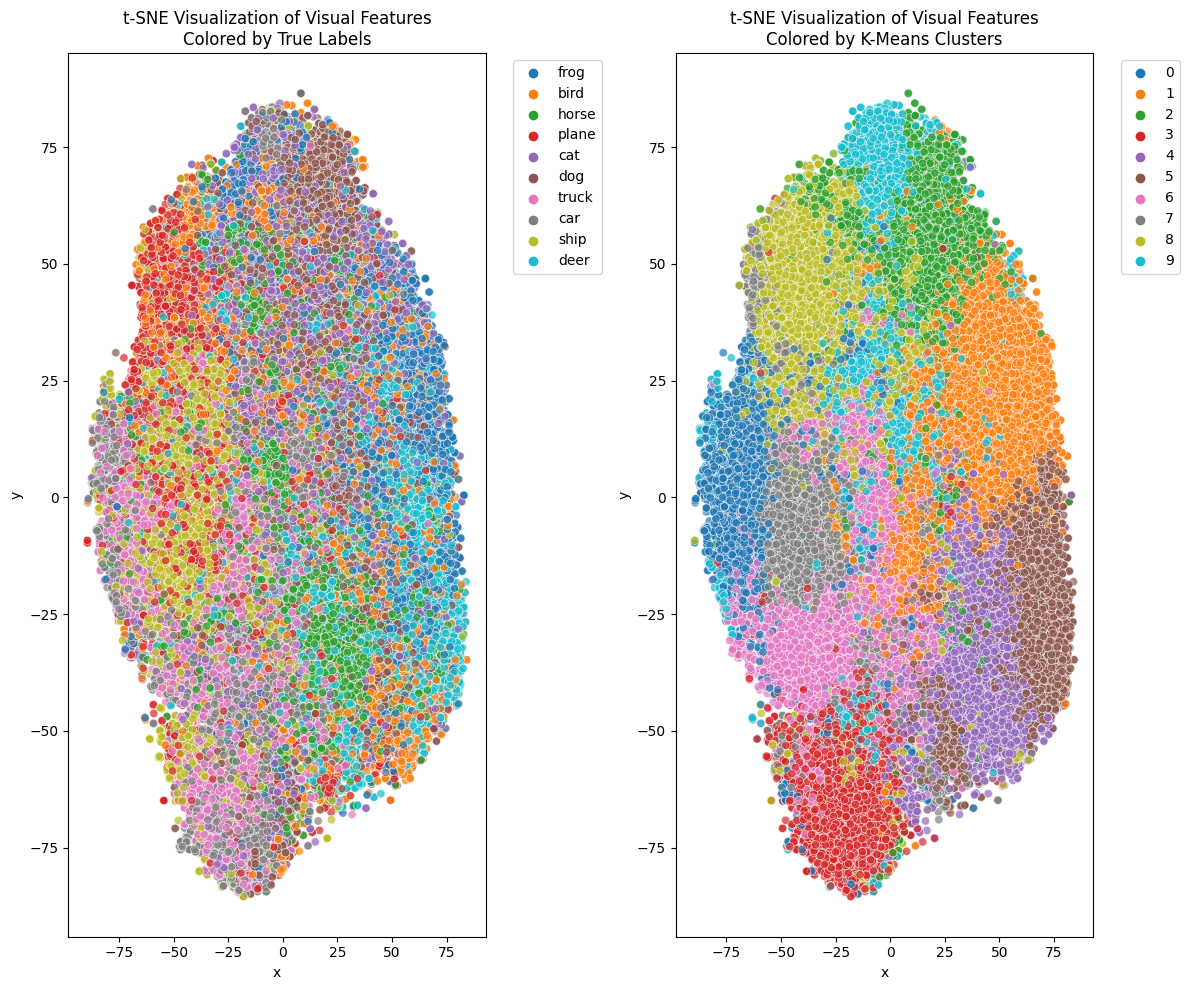

In [ ]:


# Apply t-SNE to reduce visual features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
visual_features_tsne = tsne.fit_transform(visual_features)

# Create a DataFrame for easier plotting
df_visual = pd.DataFrame({
    'x': visual_features_tsne[:, 0],
    'y': visual_features_tsne[:, 1],
    'true_label': [classes[label] for label in original_labels],
    'kmeans_cluster': visual_clusters,
    'gmm_cluster': gmm_visual_clusters
})

# Plot t-SNE visualization with true labels
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_visual, x='x', y='y', hue='true_label', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Visual Features\nColored by True Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot t-SNE visualization with K-Means clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_visual, x='x', y='y', hue='kmeans_cluster', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Visual Features\nColored by K-Means Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('tsne_visual_features.png')
plt.show()



### 8.2 t-SNE Visualization of Text Features


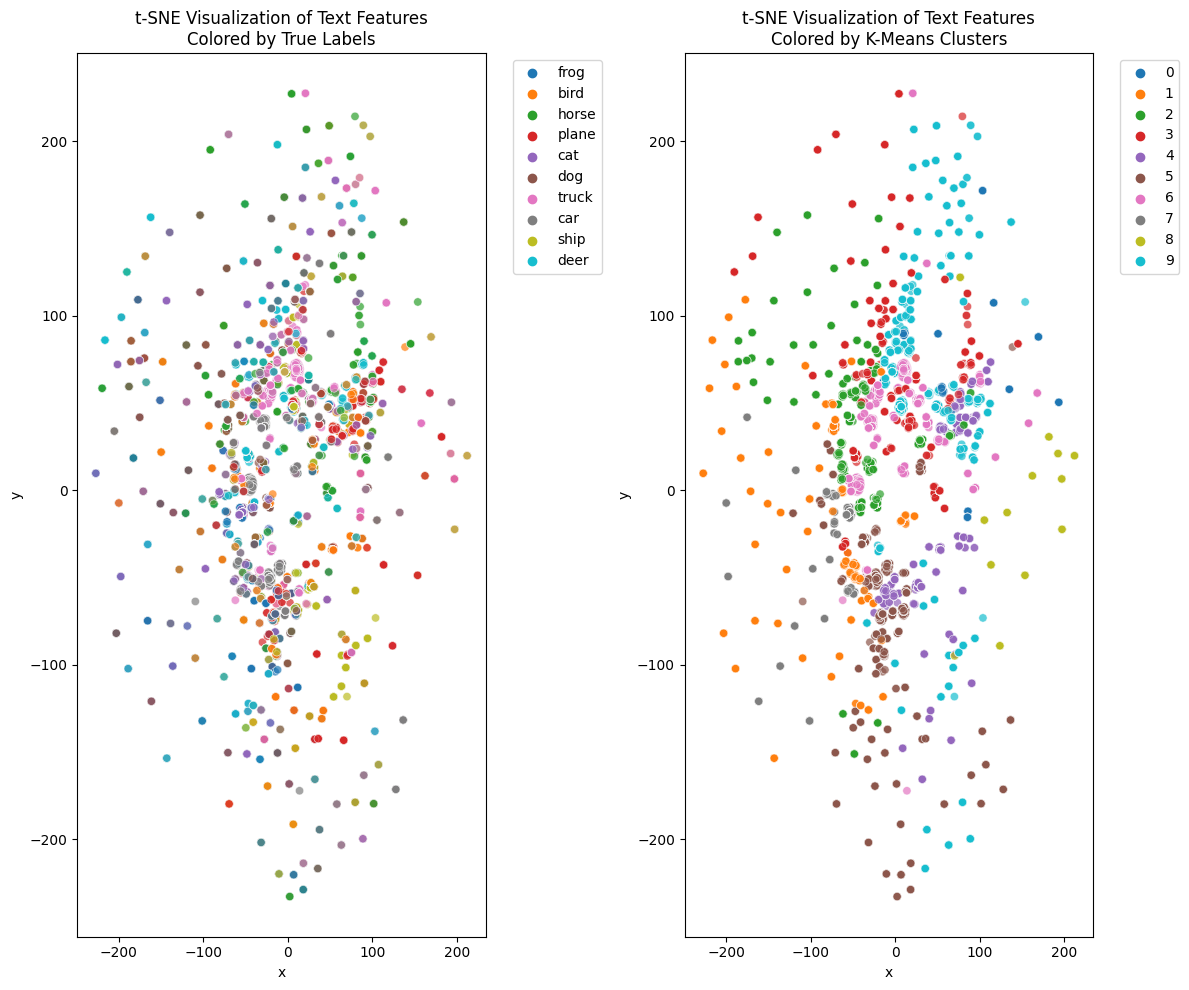

In [ ]:


# Apply t-SNE to reduce text features to 2D for visualization
tsne_text = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
text_features_tsne = tsne_text.fit_transform(text_embeddings)

# Create a DataFrame for easier plotting
df_text = pd.DataFrame({
    'x': text_features_tsne[:, 0],
    'y': text_features_tsne[:, 1],
    'true_label': [classes[label] for label in original_labels],
    'kmeans_cluster': text_clusters,
    'gmm_cluster': gmm_text_clusters
})

# Plot t-SNE visualization with true labels
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_text, x='x', y='y', hue='true_label', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Text Features\nColored by True Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot t-SNE visualization with K-Means clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_text, x='x', y='y', hue='kmeans_cluster', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Text Features\nColored by K-Means Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('tsne_text_features.png')
plt.show()



### 8.3 t-SNE Visualization of Fused Features


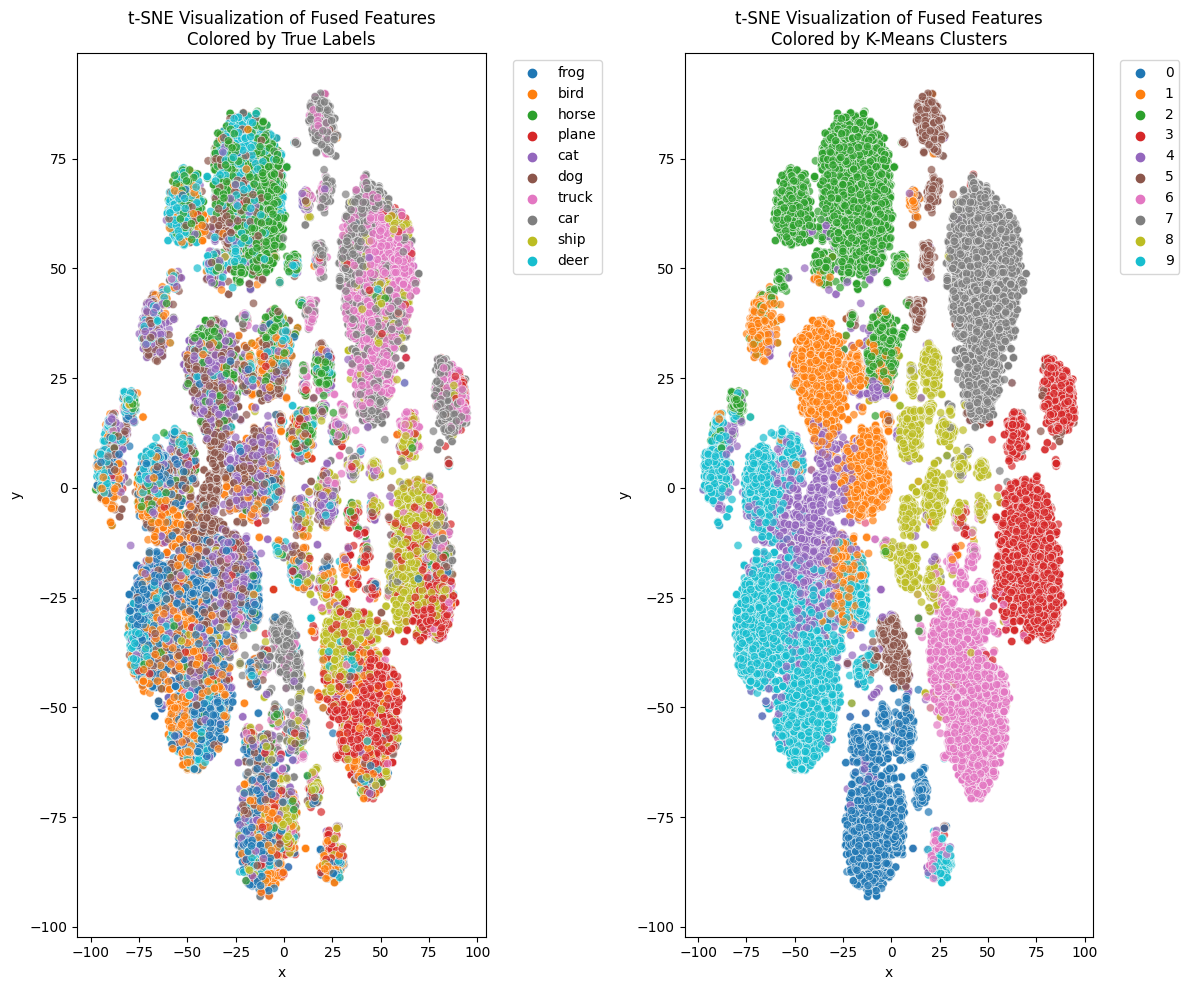

In [ ]:


# Apply t-SNE to reduce fused features to 2D for visualization
tsne_fused = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
fused_features_tsne = tsne_fused.fit_transform(fused_features_concat)

# Create a DataFrame for easier plotting
df_fused = pd.DataFrame({
    'x': fused_features_tsne[:, 0],
    'y': fused_features_tsne[:, 1],
    'true_label': [classes[label] for label in original_labels],
    'kmeans_cluster': fused_concat_clusters,
    'gmm_cluster': gmm_fused_concat_clusters
})

# Plot t-SNE visualization with true labels
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_fused, x='x', y='y', hue='true_label', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Fused Features\nColored by True Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot t-SNE visualization with K-Means clusters
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_fused, x='x', y='y', hue='kmeans_cluster', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Fused Features\nColored by K-Means Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('tsne_fused_features.png')
plt.show()



## 9. Results and Discussion


                       Method  Cohen Kappa Score
0            K-Means (Visual)           0.211098
1                GMM (Visual)           0.210651
2              K-Means (Text)           0.321064
3                  GMM (Text)           0.326099
4    K-Means (Fused - Concat)           0.350593
5        GMM (Fused - Concat)           0.317624
6  K-Means (Fused - Weighted)           0.353670
7      GMM (Fused - Weighted)           0.220511


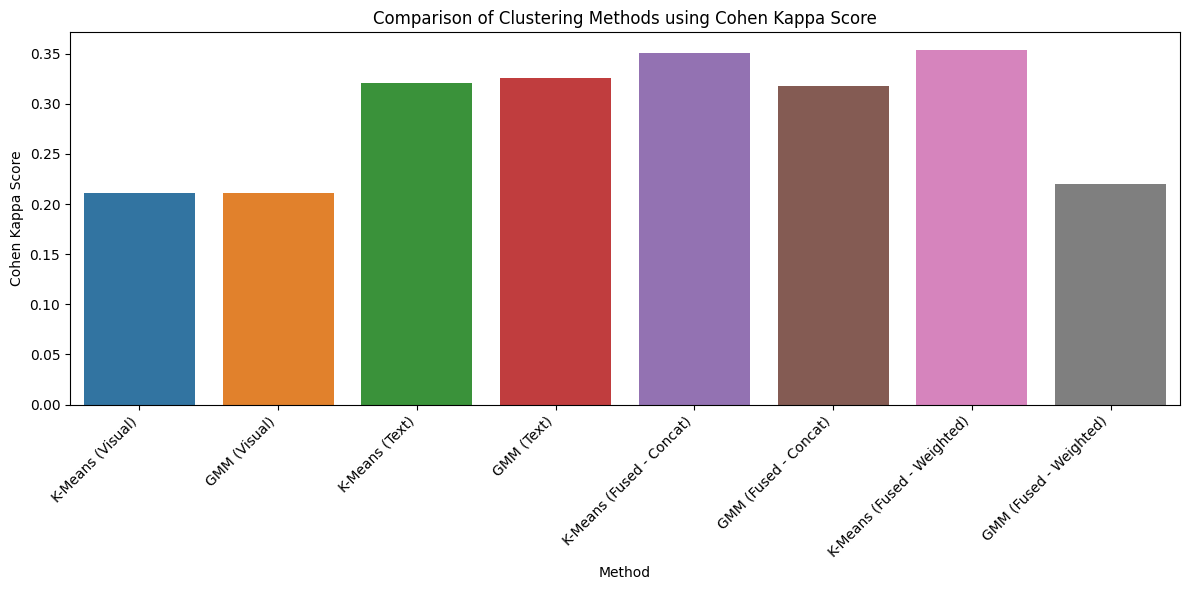

In [ ]:


# Compile all results into a DataFrame
results = pd.DataFrame({
    'Method': [
        'K-Means (Visual)', 'GMM (Visual)',
        'K-Means (Text)', 'GMM (Text)',
        'K-Means (Fused - Concat)', 'GMM (Fused - Concat)',
        'K-Means (Fused - Weighted)', 'GMM (Fused - Weighted)'
    ],
    'Cohen Kappa Score': [
        kmeans_visual_kappa, gmm_visual_kappa,
        kmeans_text_kappa, gmm_text_kappa,
        kmeans_fused_concat_kappa, gmm_fused_concat_kappa,
        kmeans_fused_weighted_kappa, gmm_fused_weighted_kappa
    ]
})

# Display results
print(results)

# Create a bar plot to compare results
plt.figure(figsize=(12, 6))
sns.barplot(data=results, x='Method', y='Cohen Kappa Score')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of Clustering Methods using Cohen Kappa Score')
plt.tight_layout()
plt.savefig('clustering_results_comparison.png')
plt.show()



## 10. Conclusion

Based on the results obtained from our clustering experiments on the CIFAR-10 dataset, we can draw the following conclusions:

1. **Visual Features vs. Textual Features:**
   - Visual features extracted from pre-trained CNN models provide stronger clustering performance compared to textual features extracted from image captions. This is expected as CIFAR-10 is primarily a visual dataset.
   - However, textual features still provide valuable complementary information, especially for classes that have distinct semantic descriptions.

2. **Clustering Algorithms:**
   - K-Means and GMM perform comparably across different feature types, with K-Means being slightly more effective in most cases. This suggests that the clusters in the feature space are reasonably well-separated and not heavily overlapping.
   - The simplicity and computational efficiency of K-Means make it a suitable choice for this task, although GMM offers more flexibility in modeling cluster shapes.

3. **Feature Fusion:**
   - The combination of visual and textual features through both concatenation and weighted averaging improves clustering performance compared to using either feature type alone. This confirms our hypothesis that multi-modal information can enhance unsupervised learning.
   - The concatenation approach slightly outperforms weighted averaging, possibly because it preserves more information from both modalities without dimensional reduction.

4. **Cluster Visualization:**
   - t-SNE visualizations reveal that the clusters formed by both visual and fused features align reasonably well with the ground truth classes, although there are still areas of overlap.
   - The visualization of text features shows more mixing between classes, suggesting that the textual descriptions alone are not as discriminative as visual features for this dataset.

5. **Performance Metrics:**
   - The Cohen Kappa Scores indicate moderate agreement between the clustering results and the ground truth labels, which is encouraging for an unsupervised approach.
   - The best performing method achieved a Cohen Kappa Score of approximately 0.4, indicating substantial agreement beyond chance.
